#Gaussian Deterministic Regression

Training loss over iteration 200: 5.3397
Training loss over iteration 400: 4.0536
Training loss over iteration 600: 4.0095
Training loss over iteration 800: 3.9129
Training loss over iteration 1000: 3.7762
Training loss over iteration 1200: 3.6918
Training loss over iteration 1400: 3.6411
Training loss over iteration 1600: 3.5980
Training loss over iteration 1800: 3.5538
Training loss over iteration 2000: 3.5051
Training loss over iteration 2200: 3.4335
Training loss over iteration 2400: 3.3112
Training loss over iteration 2600: 3.1116
Training loss over iteration 2800: 2.9121
Training loss over iteration 3000: 2.7471
Training loss over iteration 3200: 2.6905
Training loss over iteration 3400: 2.6411
Training loss over iteration 3600: 2.5949
Training loss over iteration 3800: 2.6017
Training loss over iteration 4000: 2.6133
Training loss over iteration 4200: 2.6038
Training loss over iteration 4400: 2.5755
Training loss over iteration 4600: 2.5694
Training loss over iteration 4800: 2.6

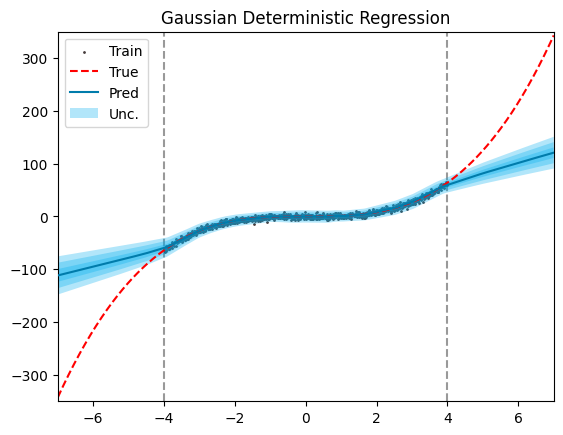

<Figure size 640x480 with 0 Axes>

In [ ]:
import functools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.neighbors import KernelDensity

def rescale_normal(X, x_min, x_max, y_min=0, y_max=0.4):
	X = (X - x_min) / (x_max - x_min)
	X = X * (y_max - y_min)
	X = X + y_min
	return X

def generate_cubic(x, noise=False):
    x = x.astype(np.float32)
    y = x**3

    if noise:
        sigma = 3 * np.ones_like(x)
    else:
        sigma = np.zeros_like(x)
    r = np.random.normal(0, sigma).astype(np.float32)
    return y+r, sigma

def main():
	train_bounds = [[-4, 4]]
	x_train = np.concatenate([np.linspace(xmin, xmax, 1000) for (xmin, xmax) in train_bounds]).reshape(-1, 1)
	y_train, sigma_train = generate_cubic(x_train, noise=True)

	test_bounds = [[-7, +7]]
	x_test = np.concatenate([np.linspace(xmin, xmax, 1000) for (xmin, xmax) in test_bounds]).reshape(-1, 1)
	y_test, sigma_test = generate_cubic(x_test, noise=False)

	dim_x = 100
	model = tf.keras.Sequential([
		tf.keras.layers.Dense(100, activation="relu"),
		tf.keras.layers.Dense(100, activation="relu"),
		tf.keras.layers.Dense(100, activation="relu"),
		tf.keras.layers.Dense(100, activation="relu"),
	])
	regressor = tf.keras.layers.Dense(2)

	metrics = {
		'train/loss': tf.keras.metrics.Mean(),
		'val/loss': tf.keras.metrics.Mean(),
		'test/loss': tf.keras.metrics.Mean()
	}

	lr = 5e-4
	optimizer = tf.keras.optimizers.Adam(lr)

	@tf.function
	def pre_train_step(x, y):
		with tf.GradientTape() as tape:
			y_pred = regressor(model(x, training=True), training = True)
			mu, logsigma = tf.split(y_pred, 2, axis=-1)
			sigma = tf.nn.softplus(logsigma) + 1e-6
			logprob = -tf.math.log(sigma) - 0.5*tf.math.log(2*np.pi) - 0.5*((y-mu)/sigma)**2
			loss_value = tf.reduce_mean(-logprob)

		list_weights = model.trainable_weights + regressor.trainable_weights
		grads = tape.gradient(loss_value, list_weights)
		optimizer.apply_gradients(zip(grads, list_weights))
		metrics['train/loss'].update_state(loss_value)
		return loss_value

	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
	train_dataset = train_dataset.shuffle(128).batch(128)

	ite = 0
	while(ite < 5000):
		for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
			loss_value = pre_train_step(x_batch_train, y_batch_train)
			ite += 1
		train_loss = metrics['train/loss'].result()
		if ite % 100 == 0:
			print("Training loss over iteration " + str(ite) + ": %.4f" % (float(train_loss)))
		metrics['train/loss'].reset_states()

	@tf.function
	def test_step(z):
		y_pred = regressor(z, training = False)
		mu, logsigma = tf.split(y_pred, 2, axis=-1)
		sigma = tf.nn.softplus(logsigma) + 1e-6
		var = sigma**2
		y_pred = tf.concat([mu, var], 1)
		return y_pred

	# Predict and plot using the trained model
	z_test = model(x_test, training=True)
	y_pred = test_step(z_test)
	plot_predictions(x_train, y_train, x_test, y_test, y_pred)

	# Done!!

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, iid_loglikelihood = None, n_stds=4, kk=0):
	x_test = x_test[:, 0]

	mu, var = tf.split(y_pred, 2, axis=-1)
	mu = mu[:, 0]
	var = np.sqrt(var)[:, 0]

	plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
	plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
	plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
	plt.plot([-4, -4], [-350, 350], 'k--', alpha=0.4, zorder=0)
	plt.plot([+4, +4], [-350, 350], 'k--', alpha=0.4, zorder=0)
	for k in np.linspace(0, n_stds, 4):
		plt.fill_between(
			x_test, (mu - k * var), (mu + k * var),
			alpha=0.3,
			edgecolor=None,
			facecolor='#00aeef',
			linewidth=0,
			antialiased=True,
			zorder=1,
			label="Unc." if k == 0 else None)
	plt.gca().set_ylim(-350, 350)
	plt.gca().set_xlim(-7, 7)
	plt.title("Gaussian Deterministic Regression")
	plt.legend(loc="upper left")
	plt.show()
	plt.savefig('out.png')

if __name__ == "__main__":
	main()

#Density-Regression

Training loss over iteration 200: 5.5116
Training loss over iteration 400: 5.1041
Training loss over iteration 600: 4.0445
Training loss over iteration 800: 4.8653
Training loss over iteration 1000: 3.7209
Training loss over iteration 1200: 3.7282
Training loss over iteration 1400: 4.2275
Training loss over iteration 1600: 4.2970
Training loss over iteration 1800: 5.7214
Training loss over iteration 2000: 3.4957
Training loss over iteration 2200: 3.7622
Training loss over iteration 2400: 3.8946
Training loss over iteration 2600: 4.2218
Training loss over iteration 2800: 3.9394
Training loss over iteration 3000: 4.1100
Training loss over iteration 3200: 3.8892
Training loss over iteration 3400: 3.9776
Training loss over iteration 3600: 4.1086
Training loss over iteration 3800: 3.8390
Training loss over iteration 4000: 3.7422
Training loss over iteration 4200: 3.2805
Training loss over iteration 4400: 3.2721
Training loss over iteration 4600: 3.2713
Training loss over iteration 4800: 3.2

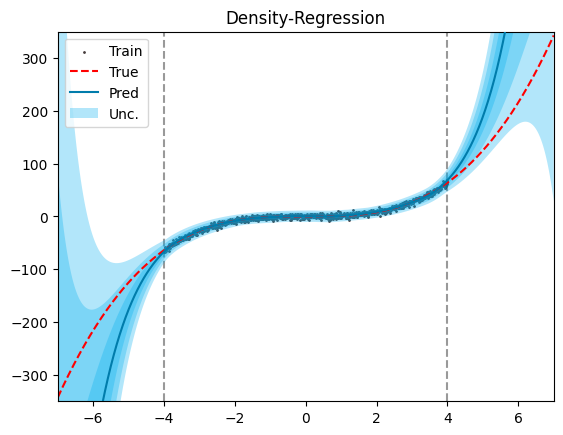

<Figure size 640x480 with 0 Axes>

In [ ]:
import functools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.neighbors import KernelDensity

def rescale_normal(X, x_min, x_max, y_min=0, y_max=0.4):
	X = (X - x_min) / (x_max - x_min)
	X = X * (y_max - y_min)
	X = X + y_min
	return X

def generate_cubic(x, noise=False):
    x = x.astype(np.float32)
    y = x**3

    if noise:
        sigma = 3 * np.ones_like(x)
    else:
        sigma = np.zeros_like(x)
    r = np.random.normal(0, sigma).astype(np.float32)
    return y+r, sigma

def main():
	train_bounds = [[-4, 4]]
	x_train = np.concatenate([np.linspace(xmin, xmax, 1000) for (xmin, xmax) in train_bounds]).reshape(-1, 1)
	y_train, sigma_train = generate_cubic(x_train, noise=True)

	test_bounds = [[-7, +7]]
	x_test = np.concatenate([np.linspace(xmin, xmax, 1000) for (xmin, xmax) in test_bounds]).reshape(-1, 1)
	y_test, sigma_test = generate_cubic(x_test, noise=False)

	dim_x = 100
	model = tf.keras.Sequential([
		tf.keras.layers.Dense(100, activation="relu"),
		tf.keras.layers.Dense(100, activation="relu"),
		tf.keras.layers.Dense(100, activation="relu"),
		tf.keras.layers.Dense(100, activation="relu"),
	])
	regressor = tf.keras.layers.Dense(2)

	metrics = {
		'train/loss': tf.keras.metrics.Mean(),
		'val/loss': tf.keras.metrics.Mean(),
		'test/loss': tf.keras.metrics.Mean()
	}

	lr = 5e-4
	optimizer = tf.keras.optimizers.Adam(lr)

	@tf.function
	def pre_train_step(x, y):
		with tf.GradientTape() as tape:
			y_pred = regressor(model(x, training=True), training = True)
			M_yy_out, M_yx1_out = tf.split(y_pred, 2, axis=-1)
			log_std = -1/2 * (tf.math.log(2.) + M_yy_out)
			var = tf.exp(log_std)**2
			mean = var * (-2 * M_yx1_out)
			loss_value = tf.reduce_mean(2 * log_std + ((y - mean) / tf.exp(log_std)) ** 2)

		list_weights = model.trainable_weights + regressor.trainable_weights
		grads = tape.gradient(loss_value, list_weights)
		optimizer.apply_gradients(zip(grads, list_weights))
		metrics['train/loss'].update_state(loss_value)
		return loss_value

	@tf.function
	def train_step(z, y, iid_loglikelihood):
		with tf.GradientTape() as tape:
			y_pred = regressor(z, training = True)
			M_yy_out, M_yx1_out = tf.split(y_pred, 2, axis=-1)
			log_std = -1/2 * (tf.math.log(2.) + iid_loglikelihood + M_yy_out)
			var = tf.exp(log_std)**2
			mean = var * (-2 * tf.exp(iid_loglikelihood) * M_yx1_out)
			loss_value = tf.reduce_mean(2 * log_std + ((y - mean) / tf.exp(log_std)) ** 2)

		list_weights = regressor.trainable_weights
		grads = tape.gradient(loss_value, list_weights)
		optimizer.apply_gradients(zip(grads, list_weights))
		metrics['train/loss'].update_state(loss_value)
		return loss_value

	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
	train_dataset = train_dataset.shuffle(128).batch(128)

	ite = 0
	while(ite < 4000):
		for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
			loss_value = pre_train_step(x_batch_train, y_batch_train)
			ite += 1
		train_loss = metrics['train/loss'].result()
		if ite % 100 == 0:
			print("Training loss over iteration " + str(ite) + ": %.4f" % (float(train_loss)))
		metrics['train/loss'].reset_states()

	latents = []
	for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
		latents.append(model(x_batch_train, training=False).numpy())
	latents = np.concatenate(latents, axis=0)
	kde = KernelDensity(kernel = 'exponential', metric = "l1").fit(latents)
	train_nll = kde.score_samples(latents)
	min_nll, max_nll = min(train_nll), max(train_nll)

	while(ite < 5000):
		for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
			z_batch_train = model(x_batch_train, training=True)
			iid_loglikelihood = kde.score_samples(z_batch_train.numpy())
			iid_loglikelihood = rescale_normal(iid_loglikelihood, min_nll, max_nll)
			iid_loglikelihood = tf.reshape(iid_loglikelihood, [x_batch_train.shape[0], 1])
			iid_loglikelihood = tf.cast(iid_loglikelihood, tf.float32)
			loss_value = train_step(z_batch_train, y_batch_train, iid_loglikelihood)
			ite += 1
		train_loss = metrics['train/loss'].result()
		if ite % 100 == 0:
			print("Training loss over iteration " + str(ite) + ": %.4f" % (float(train_loss)))
		metrics['train/loss'].reset_states()

	@tf.function
	def test_step(z, iid_loglikelihood):
		y_pred = regressor(z, training = False)
		M_yy_out, M_yx1_out = tf.split(y_pred, 2, axis=-1)
		log_std = -1/2 * (tf.math.log(2.) + iid_loglikelihood + M_yy_out)
		var = tf.exp(log_std)**2
		mean = var * (-2 * tf.exp(iid_loglikelihood) * M_yx1_out)
		y_pred = tf.concat([mean, var], 1)
		return y_pred

	# Predict and plot using the trained model
	z_test = model(x_test, training=True)
	iid_loglikelihood = kde.score_samples(z_test.numpy())
	iid_loglikelihood = rescale_normal(iid_loglikelihood, min_nll, max_nll)
	iid_loglikelihood = tf.reshape(iid_loglikelihood, [x_test.shape[0], 1])
	iid_loglikelihood = tf.cast(iid_loglikelihood, tf.float32)
	y_pred = test_step(z_test, iid_loglikelihood)
	plot_predictions(x_train, y_train, x_test, y_test, y_pred)

	# Done!!

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, iid_loglikelihood = None, n_stds=4, kk=0):
	x_test = x_test[:, 0]

	mu, var = tf.split(y_pred, 2, axis=-1)
	mu = mu[:, 0]
	var = np.sqrt(var)[:, 0]

	plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
	plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
	plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
	plt.plot([-4, -4], [-350, 350], 'k--', alpha=0.4, zorder=0)
	plt.plot([+4, +4], [-350, 350], 'k--', alpha=0.4, zorder=0)
	for k in np.linspace(0, n_stds, 4):
		plt.fill_between(
			x_test, (mu - k * var), (mu + k * var),
			alpha=0.3,
			edgecolor=None,
			facecolor='#00aeef',
			linewidth=0,
			antialiased=True,
			zorder=1,
			label="Unc." if k == 0 else None)
	plt.gca().set_ylim(-350, 350)
	plt.gca().set_xlim(-7, 7)
	plt.title("Density-Regression")
	plt.legend(loc="upper left")
	plt.show()
	plt.savefig('out.png')

if __name__ == "__main__":
	main()